<a href="https://colab.research.google.com/github/pepperamy/tenK_phase2/blob/main/shape104_of_10k_featureselection_allmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import pickle
import re
from matplotlib import pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from scipy.optimize import linear_sum_assignment
import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import mstats
import math

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.model_selection import KFold,StratifiedKFold

In [3]:
from keras import regularizers

In [4]:
from keras import backend as K

In [5]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, precision_recall_curve, classification_report,accuracy_score, auc, roc_curve, roc_auc_score, average_precision_score

In [6]:
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from keras.layers import Embedding, Dense, Conv2D, MaxPooling2D, Reshape, Conv1D, MaxPooling1D,\
Dropout, Activation, Input, Flatten, Concatenate, BatchNormalization, Lambda, LSTM, GRU, Bidirectional,\
ZeroPadding2D
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.models import Model
from keras import optimizers
from keras import metrics
from keras import models
from keras import layers

In [7]:
from sklearn.utils import class_weight

In [8]:
from sklearn import utils

In [9]:
import random

In [10]:
from sklearn.svm import LinearSVC,SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
#from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# data prepare

In [11]:
df = pd.read_csv('data_performance_words_win1_comb_20210301.csv')

In [12]:
df.shape

(53635, 212)

In [13]:
sum(df.label)

487.0

In [14]:
df.head()

,cik,y1,y2,s1,window,label,sic_class_x,rsst_acc,ch_rec,ch_inv,soft_asset,ch_cs,ch_roa,issue,aqi,asset_turnover,cfed,depi,gmi,ig,opm,rg,sg,sgee,pastavg5,pastavg3,pastavg1,cr5,cr3,cr1,WeakModal_3_avg,WeakModal_3_dis,WeakModal_3_n,WeakModal_3_new,WeakModal_3_p,WeakModal_3_u,Litigious_3_avg,Litigious_3_dis,Litigious_3_n,Litigious_3_new,...,Achieve_3_p,Achieve_3_u,Power_3_avg,Power_3_dis,Power_3_n,Power_3_new,Power_3_p,Power_3_u,Reward_3_avg,Reward_3_dis,Reward_3_n,Reward_3_new,Reward_3_p,Reward_3_u,Risk_3_avg,Risk_3_dis,Risk_3_n,Risk_3_new,Risk_3_p,Risk_3_u,WeakModal_up,WeakModal_down,Litigious_up,Litigious_down,StrongModal_up,StrongModal_down,Negative_up,Negative_down,Positive_up,Positive_down,Uncertainty_up,Uncertainty_down,Compare_up,Compare_down,Achieve_up,Achieve_down,Discrep_up,Discrep_down,Reward_up,Reward_down
0,20.0,1995.0,1996.0,0.633505,1.0,0.0,3,0.063117,-0.072425,-0.067847,0.661974,-0.147079,0.198730,1,0.974056,1.624273,0.206066,1.226305,0.914198,0.715334,0.044798,0.783539,0.814093,1.013528,NaN,NaN,NaN,NaN,NaN,NaN,-0.000071,0.000000,0.095238,0.004950,0.047619,0.761905,-0.002775,0.002801,0.190476,0.000000,...,0.047619,0.571429,-0.004527,0.016180,0.428571,0.029638,0.285714,0.190476,-0.000009,0.002644,0.190476,0.000000,0.190476,0.523810,-0.002433,0.002488,0.333333,0.019737,0.000000,0.571429,0.052570,0.095238,0.142857,0.193277,0.047619,0.058512,0.353070,0.338308,0.238095,0.292404,0.100189,0.145658,0.395804,0.355975,0.060777,0.303224,0.190476,0.248916,0.190476,0.193121
1,20.0,1996.0,1997.0,0.803827,1.0,0.0,3,0.066126,-0.018252,-0.059281,0.620435,-0.066028,0.034753,1,1.248039,1.606518,0.025826,1.088859,0.978102,0.755016,0.062466,0.938786,0.969746,1.012432,0.633505,0.633505,0.633505,1.268856,1.268856,1.268856,-0.000034,0.000000,0.066667,0.028571,0.000000,0.866667,0.003234,0.000000,0.133333,0.000000,...,0.133333,0.733333,-0.003780,0.018289,0.333333,0.000000,0.200000,0.400000,0.000668,0.007947,0.200000,0.000000,0.200000,0.533333,-0.001054,0.013954,0.066667,0.000000,0.066667,0.800000,0.028571,0.066667,0.200000,0.133333,0.161905,0.066667,0.161905,0.357243,0.200000,0.219242,0.123810,0.134598,0.333333,0.144428,0.133333,0.075494,0.133333,0.070482,0.200000,0.207947
2,20.0,1997.0,1998.0,0.462705,1.0,0.0,3,0.095900,0.066711,0.013223,0.656729,-0.030720,0.019574,1,0.840540,1.574474,0.020191,0.991780,0.991078,1.073227,0.073961,1.241132,1.022834,0.983269,0.718666,0.718666,0.803827,0.643838,0.643838,0.575627,0.002823,0.005714,0.066667,0.007841,0.133333,0.466667,-0.001499,0.004000,0.133333,0.004315,...,0.066667,0.333333,0.000062,0.028035,0.266667,0.021889,0.266667,0.133333,-0.003310,0.001504,0.266667,0.002960,0.000000,0.400000,-0.000069,0.011111,0.066667,0.004688,0.066667,0.533333,0.141174,0.072381,0.137649,0.137333,0.074024,0.139048,0.149893,0.299598,0.070786,0.271178,0.154181,0.144762,0.484144,0.236060,0.074921,0.277778,0.076624,0.202532,0.002960,0.268170
3,20.0,1998.0,1999.0,0.701689,1.0,0.0,3,0.054997,0.026323,-0.009875,0.676757,0.011434,0.002424,1,0.837833,1.604656,0.003715,1.025961,1.024634,0.948804,0.076906,1.077020,0.985921,0.983057,0.633346,0.633346,0.462705,1.107909,1.107909,1.516495,0.000590,0.006755,0.045455,0.000000,0.136364,0.545455,-0.000112,0.005460,0.090909,0.000000,...,0.090909,0.590909,0.001965,0.034894,0.090909,0.019415,0.136364,0.500000,0.000347,0.003575,0.000000,0.008179,0.045455,0.681818,-0.000126,0.003620,0.090909,0.000000,0.090909,0.545455,0.136364,0.052210,0.045455,0.096370,0.048976,0.140434,0.093257,0.110468,0.045455,0.050488,0.187374,0.063963,0.195518,0.159758,0.101197,0.055574,0.103194,0.144520,0.053633,0.003575
4,20.0,1999.0,2000.0,0.823023,1.0,0.0,3,-0.024892,-0.024929,0.041267,0.705573,-0.001713,-0.014429,1,1.093648,1.560280,-0.015406,0.942174,0.995699,1.221034,0.068754,0.933610,0.966150,1.000184,0.650432,0.656074,0.701689,1.265350,1.254468,1.172917,-0.000791,0.002083,0.176471,0.000000,0.000000,0.764706,-0.000278,0.003717,0.117647,0.000000,...,0.176471,0.647059,-0.001826,0.011784,0.117647,0.054348,0.058824,0.

In [15]:
df_fl = df[(df.y2 <= 2012) & (df.y2 >= 1995 ) ]

In [16]:
df_fl.label.value_counts()

0.0    53148
1.0      487
Name: label, dtype: int64

In [17]:
df_fl.shape

(53635, 212)

In [18]:
selected_new = ['WeakModal','Negative', 'Compare', 'Discrep','Positive',\
         'Achieve',  'Reward', 'StrongModal','Uncertainty', 'Litigious']#[::-1]

v_perf = ['aqi',
 'asset_turnover',
 'depi',
 'gmi',
 #'ig',
 'opm',
 'rg',
 'sg',
 'sgee',
 'ch_rec',
 'ch_inv',
 'soft_asset',
 'ch_cs',
 'ch_roa',
 'issue']

v_1 = ['s1']
v_2 = ['pastavg3','cr3']

In [ ]:
# selected_comb = []
# for s in selected_new:
#   selected_comb.append(s+'_up')
#   selected_comb.append(s+'_down')

In [19]:
selected_new_all = []
temp = []
for s in selected_new:
    wrd = s.split('_')[0]
    if wrd not in temp:
        #print(s,'\n',temp)
        #selected_new_all.append(wrd+'_3_avg')
        selected_new_all.append(wrd+'_3_p')
        selected_new_all.append(wrd+'_3_n')
        #selected_new_all.append(wrd+'_3_u')
        selected_new_all.append(wrd+'_3_new')
        selected_new_all.append(wrd+'_3_dis')
        temp.append(wrd)
    else: 
        pass

In [ ]:
selected_new_all

In [21]:
selected_new_all_sorted = []
selected_new_all_p = []
selected_new_all_n = []
selected_new_all_new = []
selected_new_all_dis = []
for s in selected_new_all:
  if 'new' in s.split('_'):
    selected_new_all_new.append(s)
  elif 'p' in s.split('_'):
    selected_new_all_p.append(s)
  elif 'n' in s.split('_'):
    selected_new_all_n.append(s)
  elif 'dis' in s.split('_'):
    selected_new_all_dis.append(s)

for i, w in enumerate(selected_new_all_p):
  selected_new_all_sorted.append(selected_new_all_p[i])
  selected_new_all_sorted.append(selected_new_all_new[i])
  selected_new_all_sorted.append(selected_new_all_n[i])
  
  selected_new_all_sorted.append(selected_new_all_dis[i])  


In [ ]:
selected_new_all_sorted

# SVM

In [ ]:
def svm( data, vs, label = 'label'):
    
    columns_fl = vs[1] #+ [ 'sic_class_x']
    
    data_target = data.loc[:,columns_fl + [label]]
    
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    
    class_report = []
    sum_pred_list = []

    kf = StratifiedKFold(n_splits = 4, shuffle = True)
    c = 0
    data_target = data[columns_fl + [label]]
    data_target = data_target.dropna()
    data_target = data_target.reset_index(drop = True)
    print('dataset: ', data_target.shape, '/n', sum(data_target.label))
     
    for train_index, test_index in kf.split(data_target[columns_fl],data_target[label]):
        
        c += 1

        train_x = data_target.loc[train_index,columns_fl]
        train_y = data_target.loc[train_index,label]
        test_x = data_target.loc[test_index,columns_fl]
        test_y = data_target.loc[test_index,label] 

        print('iterate_num: ', c, '\n','sum of test_y:', sum(test_y))
    
        svm = LinearSVC(class_weight = "balanced")
        svm.fit(train_x, train_y )
        pickle.dump(svm, open('svm_'+str(vs[0])+ '_'+str(c), 'wb'))
        

        pred = svm.predict(test_x)
        sum_pred_list.append(pred)
        print('sum of pred: ', sum(pred), '\n')
        # c_r = metrics.classification_report(test_y, pred, labels=[0,1], output_dict = True)
        # class_report.append(c_r)
        #print(metrics.classification_report(test_y, pred, labels=[0,1]))
        
        decision_values = svm.decision_function(test_x)
        auc_score = roc_auc_score(test_y, decision_values)
        print(auc_score)
        auc_list.append(auc_score)
        
        fpr, tpr, thresholds = roc_curve(test_y, decision_values)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        
#         mean_tpr = np.mean(tprs, axis=0)
#         mean_auc = auc(mean_fpr, mean_tpr)
        
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    frauds_prec = []
    fradus_recall = []
    for d in class_report:
        frauds_prec.append(d['1']['precision'])
        fradus_recall.append(d['1']['recall'])
    
#     coef_s = 0
#     for i in coef:
#         coef_s += abs(i)
#     coef_avg = coef_s / len(coef)
#     coef_top = pd.DataFrame(coef_avg, index = columns_fl,columns = ['importance'])
#     coef_top = coef_top.sort_values('importance',ascending=False)
#     print(coef_top.iloc[0:10,:])
        
    print('frauds_prec : ', np.mean(frauds_prec))
    print('fradus_recall : ', np.mean(fradus_recall))
    print('\n')
    return np.mean(auc_list),mean_tpr

In [ ]:
v_2

['pastavg3', 'cr3']

In [ ]:
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1, 'wrd+spc': selected_new_all +v_1,'perf+spc+wrd': v_perf +v_1 +selected_new_all}
mean_tpr_dict_svm = dict()
for fl in vs_fl.items():
#    print(fl)
    svm_model = svm( df_fl, fl,label = 'label')
    print(fl)
    print(svm_model[0])
    mean_tpr_dict_svm[fl[0]] = svm_model[1]
    print('============================')

dataset:  (53635, 15) /n 487.0
iterate_num:  1 
 sum of test_y: 122.0
sum of pred:  2913.0 

0.6566809416821817
iterate_num:  2 
 sum of test_y: 122.0
sum of pred:  2826.0 

0.6702662654363256
iterate_num:  3 
 sum of test_y: 122.0
sum of pred:  3059.0 

0.6883438391031786
iterate_num:  4 
 sum of test_y: 121.0
sum of pred:  3140.0 

0.706292797222414
avg_AUC :  0.680395960861025
avg_AUC_2 :  0.6803150390232086
frauds_prec :  nan
fradus_recall :  nan


('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
0.680395960861025
dataset:  (53635, 16) /n 487.0
iterate_num:  1 
 sum of test_y: 122.0
sum of pred:  3031.0 

0.6804672877593901
iterate_num:  2 
 sum of test_y: 122.0
sum of pred:  2782.0 

0.690804027602476
iterate_num:  3 
 sum of test_y: 122.0
sum of pred:  2779.0 

0.6875813533997855
iterate_num:  4 
 sum of test_y: 121.0
sum of pred:  2392.0 

0.6583822999800338
avg_AUC :  0.6793087421854214
a

In [ ]:
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1+v_2, 'wrd+spc': selected_new_all +v_1 +v_2,'perf+spc+wrd': v_perf +v_1 +v_2 +selected_new_all}
mean_tpr_dict_svm = dict()
for fl in vs_fl.items():
#    print(fl)
    svm_model = svm( df_fl, fl,label = 'label')
    print(fl)
    print(svm_model[0])
    mean_tpr_dict_svm[fl[0]] = svm_model[1]
    print('============================')

dataset:  (53635, 15) /n 487.0
iterate_num:  1 
 sum of test_y: 122.0
sum of pred:  3275.0 

0.6520116420956266
iterate_num:  2 
 sum of test_y: 122.0
sum of pred:  2752.0 

0.6764994009922185
iterate_num:  3 
 sum of test_y: 122.0
sum of pred:  3315.0 

0.6905615867598922
iterate_num:  4 
 sum of test_y: 121.0
sum of pred:  3018.0 

0.7086626025438398
avg_AUC :  0.6819338080978943
avg_AUC_2 :  0.681893450149784
frauds_prec :  nan
fradus_recall :  nan


('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
0.6819338080978943
dataset:  (45611, 18) /n 407.0
iterate_num:  1 
 sum of test_y: 102.0
sum of pred:  2099.0 

0.7207977430420005
iterate_num:  2 
 sum of test_y: 102.0
sum of pred:  1812.0 

0.6266571932728494
iterate_num:  3 
 sum of test_y: 102.0
sum of pred:  2005.0 

0.6721971506946289
iterate_num:  4 
 sum of test_y: 101.0
sum of pred:  1925.0 

0.6944465617254584
avg_AUC :  0.678524662183734

# LR


In [ ]:
def lg( data,vs, label = 'label'):
    
    
    columns_fl = vs[1]# + [ 'sic_class_x']
    data_target = data.loc[:,columns_fl + [label]]
    
        
#     train_x, test_x, train_y, test_y = train_test_split(data_x, data_y,test_size=0.2, random_state=19, 
#                                                                         stratify = data_y) 

    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    
    class_report = []
    sum_pred_list = []
    kf = StratifiedKFold(n_splits = 4, shuffle = True)
    c = 0
    data_target = data[columns_fl + [label]]
    data_target = data_target.dropna()
    data_target = data_target.reset_index(drop = True)
    for train_index, test_index in kf.split(data_target[columns_fl],data_target[label]):
        
        c += 1

        train_x = data_target.loc[train_index,columns_fl]
        train_y = data_target.loc[train_index,label]
        test_x = data_target.loc[test_index,columns_fl]
        test_y = data_target.loc[test_index,label] 

        print('iterate_num: ', c, '\n','sum of test_y:', sum(test_y))
    
        lg = LogisticRegression(class_weight = 'balanced')
        lg.fit(train_x, train_y )
        #pickle.dump(lg, open('lg_'+str(vs[0])+ '_'+str(c), 'wb'))

        pred = lg.predict(test_x)
        sum_pred_list.append(pred)
        print('sum of pred: ', sum(pred), '\n')
        # c_r = metrics.classification_report(test_y, pred, labels=[0,1], output_dict = True)
        # class_report.append(c_r)
        #print(metrics.classification_report(test_y, pred, labels=[0,1]))
        
        decision_values = lg.predict_proba(test_x)
        auc_score = roc_auc_score(test_y, decision_values[:,1])
        print(auc_score)
        auc_list.append(auc_score)
        fpr, tpr, thresholds = roc_curve(test_y, decision_values[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        
        #print('AUC',auc_score)
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    frauds_prec = []
    fradus_recall = []
    for d in class_report:
        frauds_prec.append(d['1']['precision'])
        fradus_recall.append(d['1']['recall'])
        
    print('frauds_prec : ', np.mean(frauds_prec))
    print('fradus_recall : ', np.mean(fradus_recall))
    print('\n')
    return np.mean(auc_list),mean_tpr

In [ ]:
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1+v_2, 'wrd+spc': selected_new_all +v_1 +v_2,'perf+spc+wrd': v_perf+v_1+v_2+selected_new_all}
mean_tpr_dict_lg = dict()
for fl in vs_fl.items():
    lg_model = lg( df_fl, fl,label = 'label')
    print(fl)
    print(lg_model[0])
    mean_tpr_dict_lg[fl[0]] = lg_model[1]
    print('============================')

iterate_num:  1 
 sum of test_y: 122.0
sum of pred:  5185.0 

0.6554570164107157
iterate_num:  2 
 sum of test_y: 122.0
sum of pred:  5224.0 

0.6747276704581207
iterate_num:  3 
 sum of test_y: 122.0
sum of pred:  5286.0 

0.6892334057571372
iterate_num:  4 
 sum of test_y: 121.0
sum of pred:  5289.0 

0.6867733141260924
avg_AUC :  0.6765478516880165
avg_AUC_2 :  0.6766746177395141
frauds_prec :  nan
fradus_recall :  nan


('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
0.6765478516880165
iterate_num:  1 
 sum of test_y: 102.0
sum of pred:  4477.0 

0.6784875882925507
iterate_num:  2 
 sum of test_y: 102.0
sum of pred:  4331.0 

0.653467244786597
iterate_num:  3 
 sum of test_y: 102.0
sum of pred:  4336.0 

0.656350036696388
iterate_num:  4 
 sum of test_y: 101.0
sum of pred:  4589.0 

0.7000729804862621
avg_AUC :  0.6720944625654495
avg_AUC_2 :  0.6722202857540656
frauds_prec :  nan
fradus_rec

# NN

In [ ]:
def model_M1(n1,n2):
    model_m1 = None
    model_m1 = Sequential(name = 'M1')
    model_m1.add(BatchNormalization())
    model_m1.add(layers.Dense(n1,name = 'layer_1',activation='relu'))
    model_m1.add(layers.Dropout(0.3))
    #model_m1.add(layers.Dense(64,name = 'layer_2'))
    model_m1.add(BatchNormalization())
    model_m1.add(layers.Dense(n2,name = 'layer_2',activation='relu'))
    model_m1.add(layers.Dense(1,activation='sigmoid'))
    
    return model_m1

In [ ]:
def performance_measure(pred_yp, y):
    '''
    Given lists of predicted y probability and x, y, return a dataframe of AR, AUC, Brier, Decile Table
    '''
    
    tenc_dat = pd.DataFrame({'y_true':y,'probability':pred_yp.flatten()})
    tenc_dat.sort_values('probability',axis = 0,ascending=False, inplace = True)
    tenc_dat.index = range(0,len(tenc_dat))
    y = tenc_dat['y_true']
    point = float(len(tenc_dat))/10
    point = int(round(point))
    tenc = []
    for i in range(0,10):
        tenc.append(y[(i*point):((i+1)*point)])
    tenc[9]=tenc[9].append(y[10*point:])
    total = sum(y)
    num_of_bkr = []
    for j in range(0,10):
        num_of_bkr.append(sum(tenc[j]))
    tencile_bkr = np.array(num_of_bkr)
    rate = tencile_bkr.astype(float)/total

    return rate

In [ ]:
class AUCEvaluation(Callback):
    """ Show AUC after interval number of epoches """
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            logs['auc'] = score
            tencile=performance_measure(y_pred, self.y_val)
            logs['tencile'] = tencile
            print(" epoch:{:d} auc: {:.4f}".format(epoch, score))

In [ ]:
def fit_model( model,x_train, y_train, x_val, y_val, x_test, y_test, model_name, verbose = 0):
    
    history = None
    result = None
    
    model_df = model
    
    #class weight for test 
    class_weights = class_weight.compute_class_weight('balanced',
                              np.unique(y_train),
                              y_train)
    class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}
    print('class_weights',class_weights)
    # class weight for val
    val_class_weights = class_weight.compute_class_weight('balanced',
                                np.unique(y_val),
                                y_val)
    val_class_weights = {l:c for l,c in zip(np.unique(y_val), val_class_weights)}
    val_sample_weights = []
    for y in y_val:
        if y == 1:
          val_sample_weights.append(val_class_weights[1])
        else: val_sample_weights.append(val_class_weights[0])
    val_sample_weights = np.asarray(val_sample_weights)
    
    
    auc_eval = AUCEvaluation(validation_data=(x_val, y_val), interval=1)
    earlyStopping = EarlyStopping(monitor='val_my_auc',patience = 3, 
                      verbose =verbose, mode ='max')
    checkpoint = ModelCheckpoint(model_name,monitor='val_my_auc',verbose=verbose,
              save_best_only=True, save_weights_only=True, mode ='max')

    opt = optimizers.RMSprop(lr=0.0005)
    model_df.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.AUC(name='my_auc')])
    
    history = model_df.fit(x_train,
                y_train,
                epochs=30,
                batch_size=512,
                callbacks=[auc_eval, earlyStopping,checkpoint], #checkpoint
                class_weight = class_weights, \
                validation_data=(x_val,y_val,val_sample_weights))
    model_df.summary()
    model_df.load_weights(model_name)
    y_pred = model_df.predict(x_test)
    y_pred_1=np.reshape(y_pred, -1)
    auc_score = roc_auc_score(y_test, y_pred_1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
    print("AUC: " ,round(auc_score,4))
        
    return history, auc_score, fpr, tpr, thresholds, [y_test, y_pred_1]

In [ ]:
def cross_val(n1, n2, data,label,columns_fl,model_name):
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    
    kf = StratifiedKFold(n_splits = 4, shuffle = True)
    c = 0
    data_1 = data[columns_fl + [label]]
    data_1 = data_1.dropna()
    data_target = data_1.reset_index(drop = True)
    
    predicted_res =[]
    print('dataset: ', data_target.shape, '/n', sum(data_target.label))
    
    
    for train_index, test_index in kf.split(data_target[columns_fl],data_target[label]):
        
        c += 1

        train_data = data_target.loc[train_index,columns_fl]
        train_label = data_target.loc[train_index,label]
        test_x = data_target.loc[test_index,columns_fl].to_numpy()
        test_y = data_target.loc[test_index,label] 

        print('iterate_num: ', c, '\n','sum of test_y:', sum(test_y))
        train_x, val_x, train_y, val_y = train_test_split(train_data.to_numpy(), train_label.to_numpy(),test_size=0.2, \
                                  random_state=42, stratify = train_label)
        print('train_x_shape',train_x.shape)
        model = model_M1(n1,n2)
        mod_res = fit_model(model, train_x, train_y, val_x, val_y, test_x, test_y, model_name+'_'+str(c)+'_NN_model')
        auc_list.append(mod_res[1])
        tprs.append(np.interp(mean_fpr, mod_res[2], mod_res[3]))
#         print(type(mod_res[-1]))
#         print(len(mod_res[-1]))
#         print(mod_res[-1])
        temp_pred_res = [mod_res[-1],test_index]
        #print(temp_pred_res)
        predicted_res.append(temp_pred_res)
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    
    return np.mean(auc_list),mean_tpr, predicted_res

In [ ]:
label = 'label'
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1+v_2, 'wrd+spc': selected_new_all +v_1 +v_2,'perf+spc+wrd': v_perf +v_1 +v_2 +selected_new_all}
#
mean_tpr_dict_nn = dict()
pred_res_nn = dict()
for fl in vs_fl.items():
    print(fl[1])
    n1 = len(fl[1])*2
    n2 = len(fl[1])
    #M1 = model_M1(n1,n2)
    NN = cross_val(n1, n2, df_fl, label, fl[1], fl[0])
    print(fl)
    print(NN[0])
    mean_tpr_dict_nn[fl[0]] = NN[1]
    pred_res_nn[fl[0]] = NN[2]

['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue']
dataset:  (53635, 15) /n 487.0
iterate_num:  1 
 sum of test_y: 122.0
train_x_shape (32180, 14)
class_weights {0.0: 0.5045785248369292, 1.0: 55.102739726027394}
Epoch 1/30
63/63 [==============================] - 3s 22ms/step - loss: 0.6696 - accuracy: 0.5970 - my_auc: 0.6232 - val_loss: 0.7130 - val_accuracy: 0.0620 - val_my_auc: 0.6273
 epoch:0 auc: 0.6262
Epoch 2/30
63/63 [==============================] - 0s 6ms/step - loss: 0.6689 - accuracy: 0.5906 - my_auc: 0.6189 - val_loss: 0.6957 - val_accuracy: 0.1341 - val_my_auc: 0.6319
 epoch:1 auc: 0.6312
Epoch 3/30
63/63 [==============================] - 0s 5ms/step - loss: 0.6808 - accuracy: 0.5722 - my_auc: 0.6723 - val_loss: 0.6752 - val_accuracy: 0.2673 - val_my_auc: 0.6530
 epoch:2 auc: 0.6531
Epoch 4/30
63/63 [==============================] - 0s 5ms/step - loss: 0.6495 - accuracy: 0.5737 - my_auc: 0.6



---



# LSTM

In [24]:
def model_lstm(n1,n2,n,w,l):
    model = None
    
    input_all = Input(shape=(w,l), \
               dtype='float32', name='input')
    nor = BatchNormalization()(input_all)
    LSTM_w_1 = Bidirectional(LSTM(n1, dropout = 0.3, recurrent_dropout = 0.3, \
              name = 'layer_lstm_1', return_sequences=True))(nor)
    LSTM_w_2 = LSTM(n2, activation='relu', dropout = 0.3, recurrent_dropout = 0.3,
                   name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)

    dense = Dense(n, activation='relu', name='dense')(LSTM_w_2)
    preds = Dense(1, activation='sigmoid', name='output')(dense)
    model = Model(inputs=input_all, outputs=preds)
    model._name = "model_lstm"
    model.summary()
    
    return model

In [ ]:
def performance_measure(pred_yp, y):
    '''
    Given lists of predicted y probability and x, y, return a dataframe of AR, AUC, Brier, Decile Table
    '''
    
    tenc_dat = pd.DataFrame({'y_true':y,'probability':pred_yp.flatten()})
    tenc_dat.sort_values('probability',axis = 0,ascending=False, inplace = True)
    tenc_dat.index = range(0,len(tenc_dat))
    y = tenc_dat['y_true']
    point = float(len(tenc_dat))/10
    point = int(round(point))
    tenc = []
    for i in range(0,10):
        tenc.append(y[(i*point):((i+1)*point)])
    tenc[9]=tenc[9].append(y[10*point:])
    total = sum(y)
    num_of_bkr = []
    for j in range(0,10):
        num_of_bkr.append(sum(tenc[j]))
    tencile_bkr = np.array(num_of_bkr)
    rate = tencile_bkr.astype(float)/total

    return rate

In [ ]:
class AUCEvaluation(Callback):
    """ Show AUC after interval number of epoches """
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            logs['auc'] = score
            tencile=performance_measure(y_pred, self.y_val)
            logs['tencile'] = tencile
            print(" epoch:{:d} auc: {:.4f}".format(epoch, score))

In [ ]:
def fit_model( model,x_train, y_train, x_val, y_val, x_test, y_test, model_name, verbose = 0):
    
    history = None
    result = None
    
    model_df = model
    
    #class weight for test 
    class_weights = class_weight.compute_class_weight('balanced',
                              np.unique(y_train),
                              y_train)
    class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}
    print(class_weights)
    # class weight for val
    val_class_weights = class_weight.compute_class_weight('balanced',
                                np.unique(y_val),
                                y_val)
    val_class_weights = {l:c for l,c in zip(np.unique(y_val), val_class_weights)}
    val_sample_weights = []
    for y in y_val:
        if y == 1:
          val_sample_weights.append(val_class_weights[1])
        else: val_sample_weights.append(val_class_weights[0])
    val_sample_weights = np.asarray(val_sample_weights)
    
    
    auc_eval = AUCEvaluation(validation_data=(x_val, y_val), interval=1)
    earlyStopping = EarlyStopping(monitor='val_my_auc',patience = 3, 
                      verbose =verbose, mode ='max')
    checkpoint = ModelCheckpoint(model_name,monitor='val_my_auc',verbose=verbose,
              save_best_only=True, save_weights_only=True, mode ='max')

    opt = optimizers.RMSprop(lr=0.0005)
    model_df.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.AUC(name='my_auc')])
    
    history = model_df.fit(x_train,
                y_train,
                epochs=30,
                batch_size=512,
                callbacks=[auc_eval, earlyStopping,checkpoint], #checkpoint
                class_weight = class_weights, \
                validation_data=(x_val,y_val,val_sample_weights)) 
    model_df.load_weights(model_name)
    y_pred = model_df.predict(x_test)
    y_pred_1=np.reshape(y_pred, -1)
    auc_score = roc_auc_score(y_test, y_pred_1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
    print("AUC: " ,round(auc_score,4))
        
    return history, auc_score, fpr, tpr, thresholds, [y_test, y_pred_1]

In [ ]:
def cross_val(data, label, perf_cols, name, w):
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    predicted_res =[]
    his_auc = []
    
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)
    c = 0

    X_perf,  Y = shift_data(df_fl, w, \
                    perf_cols, \
                    'label')
    
    for train_index, test_index in kf.split(range(len(X_perf)),Y):
        
        c += 1
        
        l1 = X_perf.shape[-1] + 16
        
        model = model_lstm(l1,l1,32,\
                    X_perf.shape[1],X_perf.shape[2])
    
        #model = model_lstm(n1,n2,n,w)
        # train_x, train_val = train_test_split(train_index,test_size=0.2, \
        #             random_state=42, stratify = Y[train_index])
        train_perf_data = X_perf[train_index]
        #train_word_data = X_word[train_x]
        #train_perf_val = X_perf[train_val]
        #train_word_val = X_word[train_val]

        train_label = Y[train_index]
        #val_label = Y[train_val]

        test_perf_x = X_perf[test_index]
        #test_word_x = X_word[test_index]
        test_y = Y[test_index] 
        
        # train_data = [train_perf_data, train_word_data]
        # val_data = [train_perf_val,train_word_val]       
        # test_x = [test_perf_x, test_word_x]

        mod_res = fit_model(model, train_perf_data, train_label, test_perf_x, test_y, test_perf_x, test_y,\
                  name+'_'+str(c))
        his_auc.append(mod_res[0].history['val_my_auc'])
        
        
        
        
        auc_list.append(mod_res[1])
        tprs.append(np.interp(mean_fpr, mod_res[2], mod_res[3]))
        temp_pred_res = [mod_res[-1],test_index]
        print(len(test_index))
        predicted_res.append(temp_pred_res)
        
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    print(pd.DataFrame(his_auc))
    print(pd.DataFrame(his_auc).mean())
    
    return np.average(auc_list), mean_tpr, predicted_res

In [ ]:
def shift_data(data, step, perf_cols, label):
    A = []
    
    cols = perf_cols #+ words_cols
    A.append(data[cols].values)
    
    for t in range(1, step):
        d = data.groupby("cik")[cols].shift(t)
        A.append(d.values)
    A = A[::-1]
    A = np.concatenate(A, axis = 1)  # flatten shifted columns
    A = np.concatenate([data[label].values[:,None], A], axis = 1)  # add target
    #np.random.shuffle(A)
    #print(A[3])
    print('init A shape: ',A.shape)
    #print(A[3,:])
    #print(data[cols].iloc[4,:])


    
    A = A[~np.isnan(A).any(axis=1)]  # drop nan
    

    Y = A[:,0]  # get target
    #A = np.reshape(A[:,1:], (len(A), step, len(cols))) # reshape

    A = np.reshape(A[:,1:], (len(A), step, len(perf_cols) + len(words_cols)))
    
    A_perf = A[:, :, 0:len(perf_cols)]
    # # CNN_LSTM must be None x T x words x 4
    # A_words = A[:, :, len(perf_cols):]
    # #convert the shape to [[_p,_new][_dis,_n]]
    # A_words = A_words.reshape((len(A), step, int(len(words_cols)/2), 2), order = 'C')
    
    print(A_perf.shape, Y.sum())
    return A_perf, Y


In [ ]:
# financial performance + overall change timestep = 3
cross_val(df_fl, 'label', v_perf + v_1, 'lstm_perf', 3)

init A shape:  (53635, 46)
(39123, 3, 15) 341.0
Model: "model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3, 15)]           0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 3, 15)             60        
_________________________________________________________________
layer_lstm_1 (LSTM)          (None, 3, 31)             5828      
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 31)                7812      
_________________________________________________________________
dense (Dense)                (None, 32)                1024      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 14,757
Trainable params: 14,727
Non-trainable params: 30
___

(0.7361061647450375,
 array([0.00294118, 0.06751026, 0.11145691, 0.149658  , 0.19069767,
        0.22294802, 0.25813953, 0.28156635, 0.30800274, 0.32852257,
        0.35492476, 0.38426813, 0.40772914, 0.42828317, 0.4370383 ,
        0.45167579, 0.46340629, 0.4751026 , 0.50153899, 0.51614227,
        0.5249316 , 0.53666211, 0.54839261, 0.55427497, 0.56894665,
        0.57770178, 0.59534884, 0.60707934, 0.6129275 , 0.6246238 ,
        0.63932969, 0.64815321, 0.65694254, 0.66863885, 0.68040356,
        0.69213406, 0.70092339, 0.70974692, 0.7126881 , 0.72151163,
        0.73614911, 0.73909029, 0.74787962, 0.75666895, 0.76545828,
        0.77718878, 0.78601231, 0.79480164, 0.80355677, 0.8123461 ,
        0.81528728, 0.81528728, 0.82407661, 0.82992476, 0.83871409,
        0.84162107, 0.84746922, 0.84746922, 0.8504104 , 0.8504104 ,
        0.85625855, 0.85625855, 0.86802326, 0.87390561, 0.88272914,
        0.89445964, 0.90328317, 0.92089603, 0.92383721, 0.92383721,
        0.93266074, 0.93556

In [ ]:
# financial performance + overall change timestep = 2
cross_val(df_fl, 'label', v_perf + v_1, 'lstm_perf', 2)

init A shape:  (53635, 31)
(45945, 2, 15) 408.0
Model: "model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 15)]           0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 2, 15)             60        
_________________________________________________________________
layer_lstm_1 (LSTM)          (None, 2, 31)             5828      
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 31)                7812      
_________________________________________________________________
dense (Dense)                (None, 32)                1024      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 14,757
Trainable params: 14,727
Non-trainable params: 30
___

(0.7103611252950334,
 array([0.        , 0.06127451, 0.09558824, 0.12254902, 0.15441176,
        0.18872549, 0.22303922, 0.24019608, 0.26715686, 0.29166667,
        0.31617647, 0.33333333, 0.35539216, 0.35784314, 0.37990196,
        0.39215686, 0.41176471, 0.43137255, 0.45098039, 0.46568627,
        0.47794118, 0.48039216, 0.50245098, 0.51470588, 0.5245098 ,
        0.53921569, 0.55147059, 0.57598039, 0.58578431, 0.59803922,
        0.60539216, 0.6127451 , 0.62745098, 0.62990196, 0.64705882,
        0.66176471, 0.66421569, 0.66666667, 0.67647059, 0.68382353,
        0.69852941, 0.70343137, 0.72303922, 0.73284314, 0.7377451 ,
        0.75245098, 0.7622549 , 0.76960784, 0.7745098 , 0.78186275,
        0.78431373, 0.79166667, 0.80147059, 0.80637255, 0.81127451,
        0.82107843, 0.82598039, 0.83088235, 0.83088235, 0.83578431,
        0.83823529, 0.85294118, 0.85784314, 0.86519608, 0.87254902,
        0.87745098, 0.88970588, 0.89460784, 0.8995098 , 0.90196078,
        0.90931373, 0.91421

In [ ]:
# financial performance timestep = 3
cross_val(df_fl, 'label', v_perf, 'lstm_perf', 3)

init A shape:  (53635, 43)
(39123, 3, 14) 341.0
Model: "model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3, 14)]           0         
_________________________________________________________________
batch_normalization_64 (Batc (None, 3, 14)             56        
_________________________________________________________________
layer_lstm_1 (LSTM)          (None, 3, 30)             5400      
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 32)                992       
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 13,801
Trainable params: 13,773
Non-trainable params: 28
___

(0.7199705384336382,
 array([0.00294118, 0.07041724, 0.10560876, 0.12609439, 0.16138851,
        0.20246238, 0.21716826, 0.2377223 , 0.25831053, 0.29353625,
        0.32582079, 0.34640903, 0.36699726, 0.37869357, 0.3874829 ,
        0.39921341, 0.40509576, 0.41976744, 0.44018468, 0.45188098,
        0.46942544, 0.48112175, 0.48984268, 0.51036252, 0.51918605,
        0.52797538, 0.53679891, 0.55735294, 0.56316689, 0.574829  ,
        0.59247606, 0.60417237, 0.6246238 , 0.64514364, 0.65102599,
        0.67746238, 0.69794802, 0.70383037, 0.70677155, 0.71556088,
        0.71846785, 0.73023256, 0.73611491, 0.74493844, 0.75666895,
        0.75961012, 0.76839945, 0.77428181, 0.78604651, 0.79189466,
        0.80068399, 0.80068399, 0.80950752, 0.82407661, 0.83290014,
        0.83874829, 0.83874829, 0.84459644, 0.85632695, 0.85923393,
        0.8621751 , 0.87387141, 0.87975376, 0.88563611, 0.89736662,
        0.89736662, 0.90913133, 0.9120383 , 0.91788646, 0.92376881,
        0.93255814, 0.93549

In [ ]:
# financial performance timestep = 2
cross_val(df_fl, 'label', v_perf, 'lstm_perf', 2)

init A shape:  (53635, 29)
(45945, 2, 14) 408.0
Model: "model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 14)]           0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 2, 14)             56        
_________________________________________________________________
layer_lstm_1 (LSTM)          (None, 2, 30)             5400      
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 32)                992       
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 13,801
Trainable params: 13,773
Non-trainable params: 28
___

(0.7039040328260695,
 array([0.00245098, 0.05882353, 0.09803922, 0.12745098, 0.16666667,
        0.17892157, 0.20588235, 0.22303922, 0.2622549 , 0.29166667,
        0.29656863, 0.31372549, 0.33823529, 0.3504902 , 0.36029412,
        0.36519608, 0.37990196, 0.39705882, 0.40686275, 0.42892157,
        0.44607843, 0.47303922, 0.47794118, 0.49019608, 0.5       ,
        0.50980392, 0.5245098 , 0.54411765, 0.56372549, 0.57843137,
        0.58578431, 0.59313725, 0.60784314, 0.6127451 , 0.62745098,
        0.64215686, 0.65196078, 0.65441176, 0.66666667, 0.68382353,
        0.70833333, 0.71813725, 0.7254902 , 0.73284314, 0.74264706,
        0.75245098, 0.75735294, 0.75980392, 0.77696078, 0.78676471,
        0.78921569, 0.79656863, 0.80392157, 0.80637255, 0.80882353,
        0.81372549, 0.82598039, 0.82598039, 0.83088235, 0.84313725,
        0.8504902 , 0.8627451 , 0.86519608, 0.87009804, 0.87254902,
        0.88480392, 0.89215686, 0.89460784, 0.90196078, 0.90196078,
        0.90196078, 0.90931

# LSTM+TCN



In [ ]:
# def model_cnn(w, num_wrds, num_depth):
#   model = None
#   input_wds = Input(shape=(w, num_wrds, 1),dtype='float32', name='input_words')

#   cov = Conv2D(4, (2,2), activation='relu')(input_wds)
#   maxpool = MaxPooling2D((1,1))(cov)
#   #reshp = Reshape((1,64))(maxpool)
#   #flt = Flatten()(maxpool)
#   model = Model(inputs=input_wds, outputs= maxpool)
#   model._name = 'cnn'          
#   model.summary()
#   return model



In [ ]:
# def model_lstm(n1, n2, n3, w, num_wrds, num_perf, num_depth):
#     model = None
    
#     input_perf = Input(shape=(1,num_perf),dtype='float32', name='input_financial')
#     input_wds = Input(shape=(w,num_wrds),dtype='float32', name='input_words')

#     cnnmodel = model_cnn(w, num_wrds, num_depth)
#     cnn_wrds = cnnmodel(input_wds)

#     reshp_perf = Reshape((1,num_perf))(input_perf)

#     concate = Concatenate(axis=-1)([cnn_wrds,input_perf])

#     #nor = BatchNormalization()(concate)
#     drop1 = Dropout(0.3)(concate)
#     #nor = BatchNormalization()(drop1)
#     # LSTM_w_1 = Bidirectional(LSTM(81,recurrent_dropout = 0.2, name = 'layer_lstm_1',\
#     #                   return_sequences=True, \
#     #                #kernel_regularizer=regularizers.l2(0.01),\
#     #                #bias_regularizer=regularizers.l2(0.01),
#     #               activity_regularizer=regularizers.l2(0.01)))(drop1)
#     LSTM_w_2 = LSTM(81,recurrent_dropout = 0.2, name = 'layer_lstm_2', \
#                 return_sequences=False )(drop1)        
#     #nor = BatchNormalization()(LSTM_w_2)
#     dense1 = Dense(81, activation='relu', name='dense1')(LSTM_w_2)
#     dense2 = Dense(n3, activation='relu', name='dense2')(dense1)
#     nor = BatchNormalization()(dense2)
#     drop2 = Dropout(0.3)(nor)
    
#     preds = Dense(1, activation='sigmoid', name='output')(drop2)
#     model = Model(inputs=[input_perf, input_wds], outputs=preds)
#     model._name = "lstm"
#     model.summary()
    
#     return model

In [ ]:
#LR
# def model_cnn_lstm(n1, n2, n3, T, perf, words, channel, filters = 24):
#     model = None
    
#     input_perf = Input(shape=(T,perf), \
#                       dtype='float32', name='input_perf')
    
#     input_words = Input(shape=(T, words, channel), \
#                       dtype='float32', name='input_words') 
    
#     word_norm = BatchNormalization()(input_words)
    
    
#     conv = Conv2D(filters = filters,\
#                   kernel_size = 1,\
#                   use_bias = False,\
#                   activation = None)(word_norm)  # Shape None x T x words x filters
#     print("conv shape:", K.int_shape(conv))
#     conv = BatchNormalization()(conv)
#     conv = Activation("relu") (conv)
    
#     pool = MaxPooling2D(pool_size=(1, words), \
#                         strides=(1,1))(conv) # None x T x filters
#     pool = Reshape((T, filters))(conv)
#     print("pool shape:", K.int_shape(pool))
    
#     #drop = Dropout(0.3)(input_all)
#     # Now concatenate
#     perf_norm = BatchNormalization()(input_perf)
#     all_input = Concatenate(axis = -1)([perf_norm, pool])
#     #nor = BatchNormalization()(all_input)
    
#     LSTM_w_1 = Bidirectional(LSTM(n1, dropout= 0.3, recurrent_dropout = 0.3,\
#                     name = 'layer_lstm_1', return_sequences=True))(all_input)
#     LSTM_w_2 = LSTM(n2, dropout= 0.3, recurrent_dropout = 0.3,
#                    name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)
    
#     dense = Dense(n3, activation='relu', name='dense')(LSTM_w_2)
#     drop = Dropout(0.3)(dense)
    
#     preds = Dense(1, activation='sigmoid', name='output')(drop)
#     model = Model(inputs=[input_perf, input_words], outputs=preds)
#     model._name = "model_cnnlstm"
#     model.summary()
    
#     return model

In [ ]:
def model_cnn_lstm_1(n1,n2,n3,T, perf, words, types ,filters = 32): #channel,
    model = None
    filters = 32
    
    input_perf = Input(shape=(T,perf), \
                      dtype='float32', name='input_perf')
    
    input_words = Input(shape=(T,words,types), \
                      dtype='float32', name='input_words')
    

    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(input_words)  # Shape None x T x words x filters
    print("conv shape 1:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    pool_1 = MaxPooling2D(pool_size= (1,17), \
                        strides=1)(conv)
    pool_1 = Reshape((T, filters))(pool_1)

    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(conv)  # Shape None x T x words x filters
    print("conv shape 2:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    pool_2 = MaxPooling2D(pool_size= (1,14), \
                        strides=1)(conv)
    pool_2 = Reshape((T, filters))(pool_2)


    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(conv)  # Shape None x T x words x filters
    print("conv shape 3:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    pool_3 = MaxPooling2D(pool_size= (1,11), \
                        strides=1)(conv)
    pool_3 = Reshape((T, filters))(pool_3)
    
    # conv = Conv2D(filters = filters,\
    #               kernel_size = (1,4),\
    #               activation = 'relu')(conv)  # Shape None x T x words x filters
    # print("conv shape 4:", K.int_shape(conv))
    # conv = BatchNormalization()(conv)
    # conv = Activation("relu") (conv)
    # pool_4 = MaxPooling2D(pool_size= (1,8), \
    #                     strides=1)(conv)
    # pool_4 = Reshape((T, filters))(pool_4)
    
    # pool = MaxPooling2D(pool_size= (1,8), \
    #                     strides=1)(conv) # None x T x filters
    
    # print("pool_init shape:", K.int_shape(pool))
    # pool = Reshape((T, filters))(pool)
    # print("pool shape:", K.int_shape(pool))
    
    #drop = Dropout(0.3)(input_all)
    # Now concatenate
    perf_norm = BatchNormalization()(input_perf)
    all_input = Concatenate(axis = -1)([perf_norm, pool_3, pool_2, pool_1 ])
    nor = BatchNormalization()(all_input)
    #drop = Dropout(0.3)(nor)
    
    LSTM_w_1 =Bidirectional(LSTM(120,  recurrent_dropout = 0.2,
                    name = 'layer_lstm_1', return_sequences=True,
                    kernel_regularizer = regularizers.l2(0.01),
                    activity_regularizer = regularizers.l2(0.01),
                    bias_regularizer = regularizers.l2(0.01)
                    ))(nor)
    LSTM_w_2 = LSTM(120, recurrent_dropout = 0.2, 
                   name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)

    dense = Dense(32, activation='relu', name='dense')(LSTM_w_2)
    nor = BatchNormalization()(dense)
    drop = Dropout(0.3)(nor)
    preds = Dense(1, activation='sigmoid', name='output')(drop)
    model = Model(inputs=[input_perf, input_words], outputs=preds)
    model._name = "model_cnnlstm_1"
    model.summary()
    
    return model

In [ ]:
def model_cnn_lstm_2(n1,n2,n3,T, perf, words, types ,filters = 32): #channel,
    model = None
    filters = 32
    
    input_perf = Input(shape=(T,perf), \
                      dtype='float32', name='input_perf')
    
    input_words = Input(shape=(T,words,types), \
                      dtype='float32', name='input_words')
    

    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(input_words)  # Shape None x T x words x filters
    print("conv shape 1:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)

    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(conv)  # Shape None x T x words x filters
    print("conv shape 2:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)


    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(conv)  # Shape None x T x words x filters
    print("conv shape 3:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    
    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(conv)  # Shape None x T x words x filters
    print("conv shape 4:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    
    pool = MaxPooling2D(pool_size= (1,8), \
                        strides=1)(conv) # None x T x filters
    
    print("pool_init shape:", K.int_shape(pool))
    pool = Reshape((T, filters))(pool)
    print("pool shape:", K.int_shape(pool))
    
    #drop = Dropout(0.3)(input_all)
    # Now concatenate
    perf_norm = BatchNormalization()(input_perf)
    all_input = Concatenate(axis = -1)([perf_norm, pool ])
    nor = BatchNormalization()(all_input)
    #drop = Dropout(0.3)(nor)
    
    LSTM_w_1 =Bidirectional(LSTM(n1,  recurrent_dropout = 0.2,
                    name = 'layer_lstm_1', return_sequences=True,
                    kernel_regularizer = regularizers.l2(0.01),
                    activity_regularizer = regularizers.l2(0.01),
                    bias_regularizer = regularizers.l2(0.01)
                    ))(nor)
    LSTM_w_2 = LSTM(n2, recurrent_dropout = 0.2, 
                   name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)

    dense = Dense(32, activation='relu', name='dense')(LSTM_w_2)
    nor = BatchNormalization()(dense)
    drop = Dropout(0.3)(nor)
    preds = Dense(1, activation='sigmoid', name='output')(drop)
    model = Model(inputs=[input_perf, input_words], outputs=preds)
    model._name = "model_cnnlstm_2"
    model.summary()
    
    return model

In [ ]:
def model_cnn_lstm_3(n1,n2,n3,T, perf, words, types ,filters = 32): #channel,
    model = None
    filters = 32
    
    input_perf = Input(shape=(T,perf), \
                      dtype='float32', name='input_perf')
    
    input_words = Input(shape=(T,words,types), \
                      dtype='float32', name='input_words')
    

    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(input_words)  # Shape None x T x words x filters
    print("conv shape 1:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    pool = MaxPooling2D(pool_size= (1,4), \
                        strides=1)(conv)

    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(pool)  # Shape None x T x words x filters
    print("conv shape 2:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    pool = MaxPooling2D(pool_size= (1,4), \
                        strides=1)(conv)

    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(pool)  # Shape None x T x words x filters
    print("conv shape 3:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    
    # conv = Conv2D(filters = filters,\
    #               kernel_size = (1,4),\
    #               activation = 'relu')(conv)  # Shape None x T x words x filters
    # print("conv shape 4:", K.int_shape(conv))
    # conv = BatchNormalization()(conv)
    # conv = Activation("relu") (conv)
    
    pool = MaxPooling2D(pool_size= (1,5), \
                        strides=1)(conv) # None x T x filters
    
    print("pool_init shape:", K.int_shape(pool))
    pool = Reshape((T, filters))(pool)
    print("pool shape:", K.int_shape(pool))
    
    #drop = Dropout(0.3)(input_all)
    # Now concatenate
    perf_norm = BatchNormalization()(input_perf)
    all_input = Concatenate(axis = -1)([perf_norm, pool ])
    nor = BatchNormalization()(all_input)
    #drop = Dropout(0.3)(nor)
    
    LSTM_w_1 =Bidirectional(LSTM(n1,  recurrent_dropout = 0.2,
                    name = 'layer_lstm_1', return_sequences=True,
                    kernel_regularizer = regularizers.l2(0.01),
                    activity_regularizer = regularizers.l2(0.01),
                    bias_regularizer = regularizers.l2(0.01)
                    ))(nor)
    LSTM_w_2 = LSTM(n2, recurrent_dropout = 0.2, 
                   name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)

    dense = Dense(32, activation='relu', name='dense')(LSTM_w_2)
    nor = BatchNormalization()(dense)
    drop = Dropout(0.3)(nor)
    preds = Dense(1, activation='sigmoid', name='output')(drop)
    model = Model(inputs=[input_perf, input_words], outputs=preds)
    model._name = "model_cnnlstm_3"
    model.summary()
    
    return model

In [ ]:
#TCN for timestep = 1
def model_tcn(n1,n2,n3,T, perf, words, channel, filters = 24, dropout = 0):
    model = None
    
    input_perf = Input(shape=(T,perf), \
                      dtype='float32', name='input_perf')
    
    input_words = Input(shape=(T,words,channel), \
                      dtype='float32', name='input_words') 
    
    word_norm = BatchNormalization()(input_words)
    padding = ZeroPadding2D(padding=((0,0),(words-1,0)))(word_norm)
    
    print("shape after padding:", K.int_shape(padding))
    
    conv = Conv2D(filters = filters,\
                  kernel_size = (1,words),\
                  use_bias = False,\
                  activation = None)(padding)  # Shape None x T x words x filters
    print("conv shape:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    
    pool = MaxPooling2D(pool_size=(1, words), \
                        strides=(1,1))(conv) # None x T x filters
    
    pool = Reshape((T, filters))(pool)
    print("pool shape:", K.int_shape(pool))
    pool = Dropout(0.3)(pool)

    #drop = Dropout(0.3)(input_all)
    # Now concatenate
    perf_norm = BatchNormalization()(input_perf)
    all_input = Concatenate(axis = -1)([perf_norm, pool])
    all_rsp = Reshape((filters+ input_perf.shape[2],))(all_input)
    #nor = BatchNormalization()(all_rsp)
    
    # LSTM_w_1 =Bidirectional(LSTM(n1,  recurrent_dropout = 0.2,
    #                 name = 'layer_lstm_1', return_sequences=True,
    #                 # kernel_regularizer = regularizers.l2(0.01),
    #                 # activity_regularizer = regularizers.l2(0.01),
    #                 # bias_regularizer = regularizers.l2(0.01)
    #                 ))(all_input)
    # LSTM_w_2 = LSTM(n2, dropout= 0.3, recurrent_dropout = 0.3,
    #                name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)
    
    dense = Dense(120, activation='relu', name='dense0')(all_rsp)
    drop = Dropout(0.3)(dense)
    dense = Dense(60, activation='relu', name='dense')(drop)
    #nor = BatchNormalization()(dense)
    #dense = Dense(24, activation='relu', name='dense2')(drop)
    preds = Dense(1, activation='sigmoid', name='output')(dense)
    model = Model(inputs=[input_perf, input_words], outputs=preds)
    model._name = "model_tcn"
    model.summary()
    
    return model
    

In [23]:
#TCN for timestep > 1
def model_tcn_1(n1,n2,n3,T, perf, words, channel, filters = 24, dropout = 0):
    model = None
    
    input_perf = Input(shape=(T,perf), \
                      dtype='float32', name='input_perf')
    
    input_words = Input(shape=(T,words,channel), \
                      dtype='float32', name='input_words') 
    
    word_norm = BatchNormalization()(input_words)
    padding = ZeroPadding2D(padding=((0,0),(words-1,0)))(word_norm)
    
    print("shape after padding:", K.int_shape(padding))
    
    conv = Conv2D(filters = filters,\
                  kernel_size = (1,words),\
                  use_bias = False,\
                  activation = None)(padding)  # Shape None x T x words x filters
    print("conv shape:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    
    pool = MaxPooling2D(pool_size=(1, words), \
                        strides=(1,1))(conv) # None x T x filters
    pool = Reshape((T, filters))(pool)
    print("pool shape:", K.int_shape(pool))

    #drop = Dropout(0.3)(input_all)
    # Now concatenate
    perf_norm = BatchNormalization()(input_perf)
    all_input = Concatenate(axis = -1)([perf_norm, pool])
    #all_rsp = Reshape((filters+15,))(all_input)
    #nor = BatchNormalization()(all_input)
    
    LSTM_w_1 =Bidirectional(LSTM(n1,  recurrent_dropout = 0.2,
                    name = 'layer_lstm_1', return_sequences=True,
                    # kernel_regularizer = regularizers.l2(0.01),
                    # activity_regularizer = regularizers.l2(0.01),
                    # bias_regularizer = regularizers.l2(0.01)
                    ))(all_input)
    LSTM_w_2 = LSTM(n2, dropout= 0.3, recurrent_dropout = 0.3,
                   name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)
    
    dense = Dense(n3, activation='relu', name='dense')(LSTM_w_2)
    drop = Dropout(0.3)(dense)
    
    preds = Dense(1, activation='sigmoid', name='output')(drop)
    model = Model(inputs=[input_perf, input_words], outputs=preds)
    model._name = "model_tcn"
    model.summary()
    
    return model

In [24]:
def performance_measure(pred_yp, y):
    '''
    Given lists of predicted y probability and x, y, return a dataframe of AR, AUC, Brier, Decile Table
    '''
    
    tenc_dat = pd.DataFrame({'y_true':y,'probability':pred_yp.flatten()})
    tenc_dat.sort_values('probability',axis = 0,ascending=False, inplace = True)
    tenc_dat.index = range(0,len(tenc_dat))
    y = tenc_dat['y_true']
    point = float(len(tenc_dat))/10
    point = int(round(point))
    tenc = []
    for i in range(0,10):
        tenc.append(y[(i*point):((i+1)*point)])
    tenc[9]=tenc[9].append(y[10*point:])
    total = sum(y)
    num_of_bkr = []
    for j in range(0,10):
        num_of_bkr.append(sum(tenc[j]))
    tencile_bkr = np.array(num_of_bkr)
    rate = tencile_bkr.astype(float)/total

    return rate

In [25]:
class AUCEvaluation(Callback):
    """ Show AUC after interval number of epoches """
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            logs['auc'] = score
            tencile=performance_measure(y_pred, self.y_val)
            logs['tencile'] = tencile
            print(" epoch:{:d} auc: {:.4f}".format(epoch, score))


In [26]:
def fit_model( model,x_train, y_train, x_val, y_val, x_test, y_test, model_name, verbose = 0):
    
    history = None
    result = None
    
    model_df = model
    print('in fit, val_y: ', sum(y_val), 'test_y',sum(y_test), 'train_y',sum(y_train))

    #class weight for test 
    class_weights = class_weight.compute_class_weight('balanced',
                              np.unique(y_train),
                              y_train)
    class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}
    # class weight for val
    val_class_weights = class_weight.compute_class_weight('balanced',
                                np.unique(y_val),
                                y_val)
    val_class_weights = {l:c for l,c in zip(np.unique(y_val), val_class_weights)}
    val_sample_weights = []
    for y in y_val:
        if y == 1:
          val_sample_weights.append(val_class_weights[1])
        else: val_sample_weights.append(val_class_weights[0])
    val_sample_weights = np.asarray(val_sample_weights)
    #print('in fit val weights', val_sample_weights.shape)
    
    auc_eval = AUCEvaluation(validation_data=(x_val, y_val), interval=1)
    # earlyStopping = EarlyStopping(monitor='val_loss',patience = 3, 
    #                   verbose =verbose, mode ='min')
    # checkpoint = ModelCheckpoint(model_name,monitor='val_my_auc',verbose=verbose,
    #           save_best_only=True, save_weights_only=True, mode ='max')

    opt = optimizers.RMSprop(lr=0.0005)
    model_df.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.AUC(name='my_auc')])

    history = model_df.fit(x_train,
                y_train,
                epochs=25,
                batch_size=128,
                verbose =verbose,
                callbacks=[auc_eval],\
                #callbacks=[auc_eval, earlyStopping, checkpoint], #checkpoint
                class_weight = class_weights, \
                validation_data=(x_val, y_val, val_sample_weights)) 
    model_df.save(model_name+".h5")
    #model_df.load_weights(model_name)
    y_pred = model_df.predict(x_test)
    y_pred_1=np.reshape(y_pred, -1)
    auc_score = roc_auc_score(y_test, y_pred_1)
    #auc_score = roc_auc_score(y_test, y_pred_1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
    print("AUC: " ,round(auc_score,4))
    print([ round(h,4) for h in history.history['val_loss']])    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

        
    return history, auc_score, fpr, tpr, thresholds, [y_test, y_pred_1]

In [27]:
def cross_val(data, label, perf_cols, words_cols, name, w, filters = 24):
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    predicted_res =[]
    his_auc = []
    
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)
    c = 0

    X_perf, X_word, Y = shift_data(df_fl, w, \
                    perf_cols, \
                    words_cols, \
                    'label')
    
    for train_index, test_index in kf.split(range(len(X_perf)),Y):
        
        c += 1
        
        l1 = X_perf.shape[-1]+ filters + 16
        
        model = model_tcn_1(l1,l1,32,\
                    X_perf.shape[1],\
                    X_perf.shape[2],
                    X_word.shape[2], \
                    X_word.shape[3], \
                    filters = filters)
    
        #model = model_lstm(n1,n2,n,w)
        # train_x, train_val = train_test_split(train_index,test_size=0.2, \
        #             random_state=42, stratify = Y[train_index])
        train_perf_data = X_perf[train_index]
        train_word_data = X_word[train_index]
        # train_perf_val = X_perf[train_val]
        # train_word_val = X_word[train_val]

        train_label = Y[train_index]
        #val_label = Y[train_val]

        test_perf_x = X_perf[test_index]
        test_word_x = X_word[test_index]
        test_y = Y[test_index] 
        
        train_data = [train_perf_data, train_word_data]
        #val_data = [train_perf_val,train_word_val]
        test_x = [test_perf_x, test_word_x]

        mod_res = fit_model(model, train_data, train_label, test_x, test_y, test_x, test_y,\
                  name+'_'+str(c))
        his_auc.append(mod_res[0].history['val_my_auc'])
        
        
        
        
        auc_list.append(mod_res[1])
        tprs.append(np.interp(mean_fpr, mod_res[2], mod_res[3]))
        temp_pred_res = [mod_res[-1],test_index]
        print(len(test_index))
        predicted_res.append(temp_pred_res)
        
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    print(pd.DataFrame(his_auc))
    print(pd.DataFrame(his_auc).mean())
    
    return np.average(auc_list), mean_tpr, predicted_res

In [ ]:
#a = np.arange(16).reshape((2,8#))

In [ ]:
#a

In [ ]:
#a.reshape((2,8), order = '')

In [ ]:
#a.reshape((2,4,2), order = 'C')

In [28]:
def shift_data(data, step, perf_cols, words_cols, label):
    A = []
    
    cols = perf_cols + words_cols
    A.append(data[cols].values)
    
    for t in range(1, step):
        d = data.groupby("cik")[cols].shift(t)
        A.append(d.values)
    A = A[::-1]
    A = np.concatenate(A, axis = 1)  # flatten shifted columns
    A = np.concatenate([data[label].values[:,None], A], axis = 1)  # add target
    #np.random.shuffle(A)
    #print(A[3])
    print('init A shape: ',A.shape)
    #print(A[3,:])
    #print(data[cols].iloc[4,:])


    
    A = A[~np.isnan(A).any(axis=1)]  # drop nan
    

    Y = A[:,0]  # get target
    #A = np.reshape(A[:,1:], (len(A), step, len(cols))) # reshape

    A = np.reshape(A[:,1:], (len(A), step, len(perf_cols) + len(words_cols)))
    
    A_perf = A[:, :, 0:len(perf_cols)]
    # CNN_LSTM must be None x T x words x 4
    A_words = A[:, :, len(perf_cols):]
    #convert the shape to [[_p,_new][_dis,_n]]
    A_words = A_words.reshape((len(A), step, int(len(words_cols)/4), 4), order = 'C')
    
    print(A_perf.shape, A_words.shape, Y.sum())
    return A_perf, A_words, Y


In [31]:
#shift_perf,shit_wrd, _y = shift_data(df_fl, 3, v_perf + v_1+ v_2, selected_new_all_sorted, label='label')

init A shape:  (53635, 172)
(53635, 3, 17) (53635, 3, 10, 4) 487.0


In [ ]:
#shit_wrd[2]

In [ ]:
# for k , fr in df_fl.groupby("cik"):
#   print(fr[selected_new_all_sorted])
#   break

In [29]:
import os, random

seed_value = 43
os.environ['PYTHONASHSEED'] = str(seed_value)

random.seed(seed_value)

from numpy.random import seed
seed(seed_value)

import tensorflow
tensorflow.random.set_seed(seed_value)


 ======= v_1 and word changes =========
init A shape:  (53635, 42)
(53635, 1, 1) (53635, 1, 20, 2) 487.0
shape after padding: (None, 1, 39, 2)
conv shape: (None, 1, 20, 32)
pool shape: (None, 1, 32)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 1, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 1, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, 1, 39, 2)     0           batch_normalization_30[0][0]     
________________________________________________________________________________________

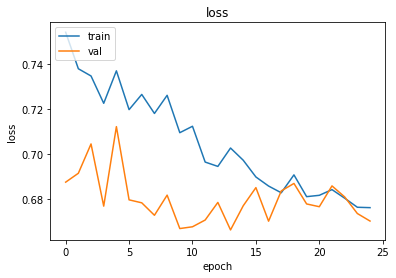

13409
shape after padding: (None, 1, 39, 2)
conv shape: (None, 1, 20, 32)
pool shape: (None, 1, 32)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 1, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 1, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, 1, 39, 2)     0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 1, 20, 32)    1280        zero_padding2d_11[0][0] 

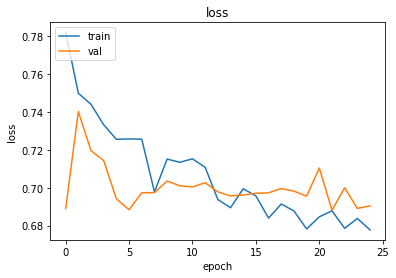

13409
shape after padding: (None, 1, 39, 2)
conv shape: (None, 1, 20, 32)
pool shape: (None, 1, 32)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 1, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 1, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_12 (ZeroPadding2 (None, 1, 39, 2)     0           batch_normalization_36[0][0]     
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 1, 20, 32)    1280        zero_padding2d_12[0][0] 

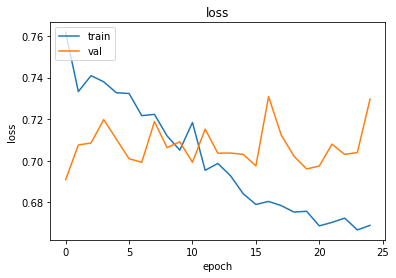

13409
shape after padding: (None, 1, 39, 2)
conv shape: (None, 1, 20, 32)
pool shape: (None, 1, 32)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 1, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 1, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_13 (ZeroPadding2 (None, 1, 39, 2)     0           batch_normalization_39[0][0]     
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 1, 20, 32)    1280        zero_padding2d_13[0][0] 

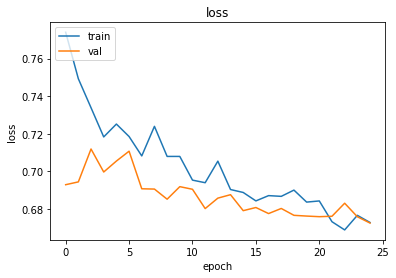

13408
avg_AUC :  0.5883563454318619
avg_AUC_2 :  0.5884064188833189
         0         1         2   ...        22        23        24
0  0.587531  0.544261  0.596751  ...  0.596036  0.610786  0.623141
1  0.566061  0.566428  0.581329  ...  0.579069  0.583588  0.574250
2  0.564725  0.541125  0.543345  ...  0.550031  0.542859  0.544365
3  0.547570  0.566860  0.549487  ...  0.612078  0.613981  0.611968

[4 rows x 25 columns]
0     0.566472
1     0.554669
2     0.567728
3     0.571019
4     0.573187
5     0.583220
6     0.578185
7     0.556694
8     0.558094
9     0.555870
10    0.560069
11    0.573628
12    0.586489
13    0.603665
14    0.576766
15    0.579724
16    0.590451
17    0.577232
18    0.573307
19    0.583257
20    0.587201
21    0.590656
22    0.584303
23    0.587803
24    0.588431
dtype: float64


In [ ]:
print("\n ======= v_1 and word changes =========")

result = []

# First choose all varaibles
#cols = v_perf + v_1+ v_2 + selected_new_all #must order like this
w = 1
perf_cols = v_1
words_cols = selected_new_all_sorted
label = 'label'
h = cross_val( df_fl, 'label', \
          perf_cols,\
          words_cols, \
          'model_tcn',w, \
          filters = 32)



 ======= v_1 perf and word changes =========
init A shape:  (53635, 56)
(53635, 1, 15) (53635, 1, 10, 4) 487.0
shape after padding: (None, 1, 19, 4)
conv shape: (None, 1, 10, 46)
pool shape: (None, 1, 46)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 1, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 1, 19, 4)     0           batch_normalization[0][0]        
__________________________________________________________________________________

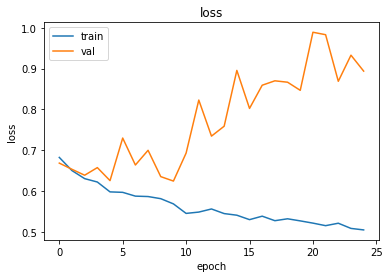

13409
shape after padding: (None, 1, 19, 4)
conv shape: (None, 1, 10, 46)
pool shape: (None, 1, 46)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 1, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 1, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 1, 19, 4)     0           batch_normalization_3[0][0]      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 10, 46)    1840        zero_padding2d_1[0][0]  

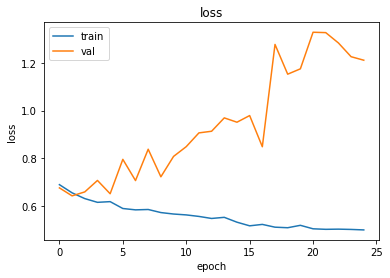

13409
shape after padding: (None, 1, 19, 4)
conv shape: (None, 1, 10, 46)
pool shape: (None, 1, 46)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 1, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 1, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 1, 19, 4)     0           batch_normalization_6[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1, 10, 46)    1840        zero_padding2d_2[0][0]  

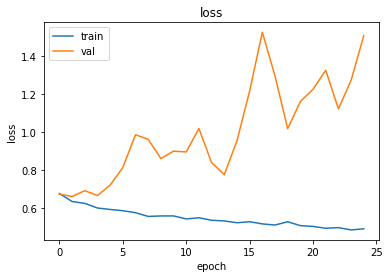

13409
shape after padding: (None, 1, 19, 4)
conv shape: (None, 1, 10, 46)
pool shape: (None, 1, 46)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 1, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 1, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 1, 19, 4)     0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 1, 10, 46)    1840        zero_padding2d_3[0][0]  

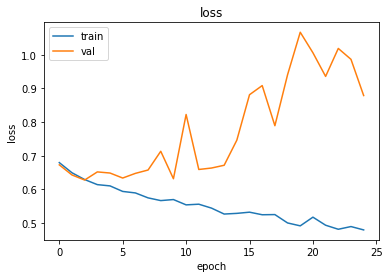

13408
avg_AUC :  0.6781075522751819
avg_AUC_2 :  0.6777288020429193
         0         1         2   ...        22        23        24
0  0.676762  0.656866  0.700991  ...  0.658789  0.654101  0.678175
1  0.663998  0.700526  0.689793  ...  0.674898  0.651551  0.662704
2  0.666820  0.672966  0.671560  ...  0.705010  0.697596  0.675809
3  0.677412  0.695893  0.702566  ...  0.658423  0.664577  0.684466

[4 rows x 25 columns]
0     0.671248
1     0.681563
2     0.691227
3     0.693421
4     0.691366
5     0.678284
6     0.687191
7     0.677873
8     0.686256
9     0.692775
10    0.678489
11    0.676227
12    0.675775
13    0.684188
14    0.674563
15    0.683191
16    0.668444
17    0.666069
18    0.674400
19    0.673547
20    0.668851
21    0.670608
22    0.674280
23    0.666956
24    0.675289
dtype: float64


In [30]:
print("\n ======= v_1 perf and word changes =========")

result = []

# First choose all varaibles
#cols = v_perf + v_1+ v_2 + selected_new_all #must order like this
w = 1
perf_cols = v_perf + v_1
words_cols = selected_new_all_sorted
label = 'label'
h = cross_val( df_fl, 'label', \
          perf_cols,\
          words_cols, \
          'model_tcn',w, \
          filters = 46)



 ======= v_1 and word changes =========
init A shape:  (53635, 166)
(39123, 3, 15) (39123, 3, 10, 4) 341.0
shape after padding: (None, 3, 19, 4)
conv shape: (None, 3, 10, 26)
pool shape: (None, 3, 26)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 3, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_12 (ZeroPadding2 (None, 3, 19, 4)     0           batch_normalization_36[0][0]     
______________________________________________________________________________________

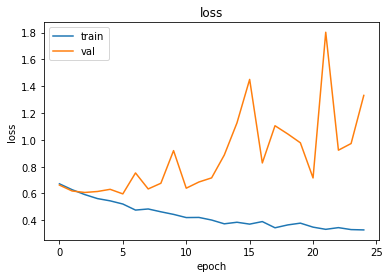

9781
shape after padding: (None, 3, 19, 4)
conv shape: (None, 3, 10, 26)
pool shape: (None, 3, 26)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 3, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_13 (ZeroPadding2 (None, 3, 19, 4)     0           batch_normalization_39[0][0]     
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 3, 10, 26)    1040        zero_padding2d_13[0][0]  

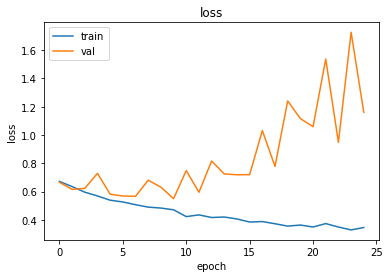

9781
shape after padding: (None, 3, 19, 4)
conv shape: (None, 3, 10, 26)
pool shape: (None, 3, 26)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 3, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_14 (ZeroPadding2 (None, 3, 19, 4)     0           batch_normalization_42[0][0]     
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 3, 10, 26)    1040        zero_padding2d_14[0][0]  

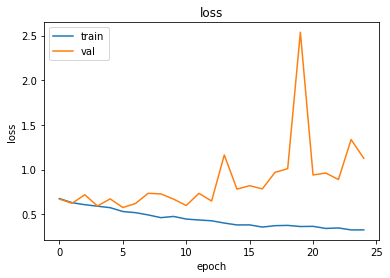

9781
shape after padding: (None, 3, 19, 4)
conv shape: (None, 3, 10, 26)
pool shape: (None, 3, 26)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 10, 4)]   0                                            
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 3, 10, 4)     16          input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_15 (ZeroPadding2 (None, 3, 19, 4)     0           batch_normalization_45[0][0]     
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 3, 10, 26)    1040        zero_padding2d_15[0][0]  

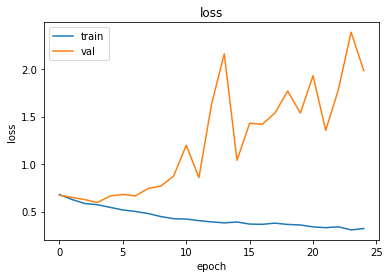

9780
avg_AUC :  0.7855966609984428
avg_AUC_2 :  0.7853891168870649
         0         1         2   ...        22        23        24
0  0.725656  0.741710  0.750943  ...  0.785359  0.783810  0.755236
1  0.691585  0.720577  0.743659  ...  0.777894  0.753034  0.782489
2  0.683502  0.707130  0.711820  ...  0.791507  0.786450  0.769116
3  0.693517  0.698771  0.736852  ...  0.739788  0.718770  0.724613

[4 rows x 25 columns]
0     0.698565
1     0.717047
2     0.735819
3     0.749899
4     0.752848
5     0.770788
6     0.770864
7     0.776946
8     0.770761
9     0.765723
10    0.777052
11    0.793010
12    0.772629
13    0.761763
14    0.776135
15    0.772157
16    0.777578
17    0.772602
18    0.768066
19    0.750547
20    0.783140
21    0.760935
22    0.773637
23    0.760516
24    0.757864
dtype: float64


In [39]:
print("\n ======= v_1 and word changes =========")

result = []

# First choose all varaibles
#cols = v_perf + v_1+ v_2 + selected_new_all #must order like this
w = 3
perf_cols = v_1 +v_perf
words_cols = selected_new_all_sorted
label = 'label'
h = cross_val( df_fl, 'label', \
          perf_cols,\
          words_cols, \
          'model_tcn_w3',w, \
          filters = 26)



 ======= v_1 and word changes =========
init A shape:  (53635, 83)
(45945, 2, 1) (45945, 2, 20, 2) 408.0
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_78 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_20 (ZeroPadding2 (None, 2, 39, 2)     0           batch_normalization_78[0][0]     
________________________________________________________________________________________

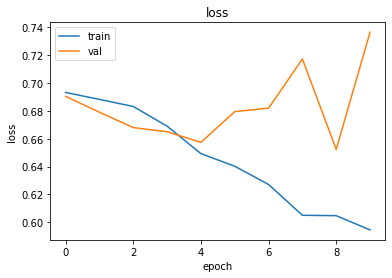

11487
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_81 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_21 (ZeroPadding2 (None, 2, 39, 2)     0           batch_normalization_81[0][0]     
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 2, 20, 24)    960         zero_padding2d_21[0][0] 

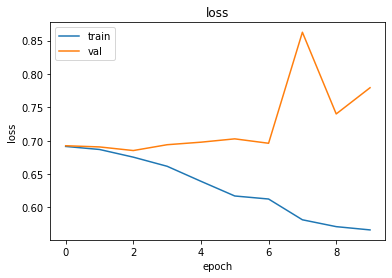

11486
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_22 (ZeroPadding2 (None, 2, 39, 2)     0           batch_normalization_84[0][0]     
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 2, 20, 24)    960         zero_padding2d_22[0][0] 

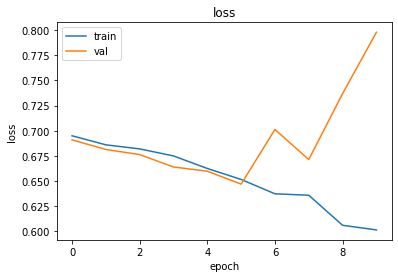

11486
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_87 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_23 (ZeroPadding2 (None, 2, 39, 2)     0           batch_normalization_87[0][0]     
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 2, 20, 24)    960         zero_padding2d_23[0][0] 

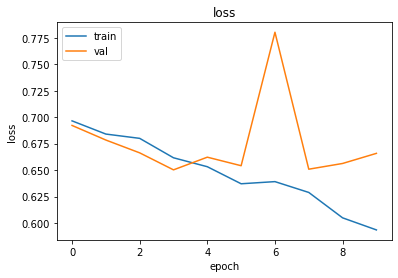

11486
avg_AUC :  0.6782565329677348
avg_AUC_2 :  0.6781417112299465
          0         1         2  ...         7         8         9
0  0.596460  0.619182  0.645461  ...  0.669859  0.676715  0.679949
1  0.552030  0.558218  0.581191  ...  0.626367  0.635713  0.642428
2  0.574998  0.596124  0.622779  ...  0.687667  0.686478  0.698155
3  0.569429  0.623111  0.646964  ...  0.666409  0.688852  0.691964

[4 rows x 10 columns]
0    0.573229
1    0.599159
2    0.624099
3    0.636544
4    0.642360
5    0.651814
6    0.655250
7    0.662576
8    0.671939
9    0.678124
dtype: float64


In [ ]:
print("\n ======= v_1 and word changes =========")

result = []

# First choose all varaibles
#cols = v_perf + v_1+ v_2 + selected_new_all #must order like this
w = 2
perf_cols = v_1
words_cols = selected_new_all_sorted
label = 'label'
h = cross_val( df_fl, 'label', \
          perf_cols,\
          words_cols, \
          'model_tcn',w, \
          filters = 24)
    


 ======= Select columns for LSTM ALL OBS.=========
init A shape:  (53635, 166)
(39123, 3, 15) (39123, 3, 20, 2) 341.0
shape after padding: (None, 3, 39, 2)
conv shape: (None, 3, 20, 32)
pool shape: (None, 3, 32)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 3, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, 3, 39, 2)     0           batch_normalization_33[0][0]     
___________________________________________________________________________

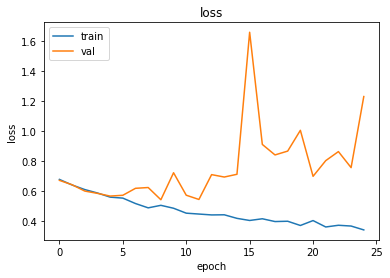

9781
shape after padding: (None, 3, 39, 2)
conv shape: (None, 3, 20, 32)
pool shape: (None, 3, 32)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 3, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_12 (ZeroPadding2 (None, 3, 39, 2)     0           batch_normalization_36[0][0]     
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 3, 20, 32)    1280        zero_padding2d_12[0][0]  

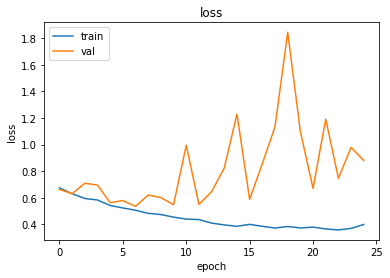

9781
shape after padding: (None, 3, 39, 2)
conv shape: (None, 3, 20, 32)
pool shape: (None, 3, 32)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 3, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_13 (ZeroPadding2 (None, 3, 39, 2)     0           batch_normalization_39[0][0]     
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 3, 20, 32)    1280        zero_padding2d_13[0][0]  

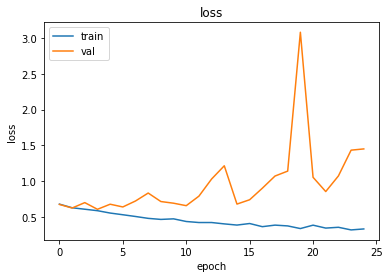

9781
shape after padding: (None, 3, 39, 2)
conv shape: (None, 3, 20, 32)
pool shape: (None, 3, 32)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 3, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_14 (ZeroPadding2 (None, 3, 39, 2)     0           batch_normalization_42[0][0]     
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 3, 20, 32)    1280        zero_padding2d_14[0][0]  

In [ ]:

print("\n ======= Select columns for LSTM ALL OBS.=========")

result = []

# First choose all varaibles
#cols = v_perf + v_1+ v_2 + selected_new_all #must order like this
w = 3
perf_cols = v_perf + v_1
words_cols = selected_new_all_sorted
label = 'label'
h = cross_val( df_fl, 'label', \
          perf_cols,\
          words_cols, \
          'model_tcn_w3',w, \
          filters = 32)
    
#best_auc = h[0]

# Next, remove one from the list each time



In [ ]:
#best_auc

0.752735165519567

In [ ]:

#all_cols = selected_new_all

# selected_cols = selected_new_all + v_1 + v_2
# random.shuffle(selected_cols)

# for col in selected_cols:
    
#     print("\n ===========Test {}============\n".format(col))
    
#     test_cols = [item for item in selected_cols if item !=col]
#     #test_cols = v_perf + v_1+ v_2 + [col]
    
#     # n1 = 2*len(test_cols)
#     # n2 = len(test_cols)
#     label = 'label'
#     h = cross_val( df_fl, label, test_cols + v_perf, 'lstm_wds', 2)

#     gap = h[0] - best_auc
#     print('****** gap: {0:.4f}'.format(gap))
    
#     result.append([col, h[0], best_auc, gap]) #gap
    
#     if h[0]>= best_auc:  # better to drop col
        
#         selected_cols = test_cols
        
#         best_auc = h[0]
        
#         print("*** {} removed ***".format(col))
    
#     print("current auc: {0:.4f}\tbest_auc: {1:.4f}\tcolumn: {2}".format(h[0], best_auc, col))
#     print("selected columns: ", selected_cols)


# pd.DataFrame(result, columns = ["column", "auc", "prev_auc","gap"]).to_csv("var_selection_lstm_bi_2.csv")   

In [ ]:
print(random.shuffle(selected_new_all))

In [ ]:
'Litigious_3_dis' in list(df_fl.columns)

True